In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from workflows.sql_workflow import SQLWorkflow
from models.graph_state import GraphState
from models.llm import CHATLLM, BASELLM
from utils.data_utils import load_csv_to_sqlite
from configs.examples import EXAMPLES
from configs.schemas import SCHEMAS
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langgraph.errors import GraphRecursionError
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [26]:
csv_files = {
    "data/PET_PLACES.csv": "PET_PLACES",
    "data/CHILDREN_PLACES.csv": "CHILDREN_PLACES",
}

conn = load_csv_to_sqlite(csv_files)
embeddings = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

questions = [item["question"] for item in EXAMPLES]
question_embeddings = [
    (question, embeddings.embed_query(question)) for question in questions
]
vectorstore_examples = FAISS.from_embeddings(
    text_embeddings=question_embeddings, embedding=embeddings, metadatas=EXAMPLES
)

c:\Users\jiyoo\OneDrive\PrompTart\TourGuideRAG
Loaded data/PET_PLACES.csv into table 'PET_PLACES'.
Loaded data/CHILDREN_PLACES.csv into table 'CHILDREN_PLACES'.


In [27]:
vectorstore_examples.save_local("faiss_example")

In [29]:
# Load FAISS index
vector_store = FAISS.load_local(
    "faiss_example", embeddings, allow_dangerous_deserialization=True
)

# Perform similarity search without embedding again
query = "24시간 운영하는 동물병원"
results = vector_store.similarity_search_with_score(query, k=3)

# Display results
for doc, score in results:
    print(f"Text: {doc}")

Text: page_content='서울 강남구에서 운영시간이 24시간인 동물병원을 알려주세요.' metadata={'question': '서울 강남구에서 운영시간이 24시간인 동물병원을 알려주세요.', 'sql': "SELECT * FROM PET_PLACES WHERE LAND_LOT_ADDRESS LIKE '%서울특별시%강남구%' AND OPERATION_TIME LIKE '%00:00~24:00%'", 'source': 'pet_places'}
Text: page_content='경기도에서 일요일에도 영업하는 반려동물 병원을 찾고 싶어요.' metadata={'question': '경기도에서 일요일에도 영업하는 반려동물 병원을 찾고 싶어요.', 'sql': "SELECT * FROM PET_PLACES WHERE LAND_LOT_ADDRESS LIKE '%경기도%' AND CATEGORY_NM = '동물병원' AND OPERATION_TIME LIKE '%일요일%'", 'source': 'pet_places'}
Text: page_content='부산시 동구에 있는 동물병원을 알려주세요.' metadata={'question': '부산시 동구에 있는 동물병원을 알려주세요.', 'sql': "SELECT * FROM PET_PLACES WHERE LAND_LOT_ADDRESS LIKE '%부산광역시%동구%' AND CATEGORY_NM = '동물병원'", 'source': 'pet_places'}


In [17]:
tour_rag = SQLWorkflow(CHATLLM, CHATLLM, vectorstore_examples)
app = tour_rag.setup_workflow()

c:\Users\jiyoo\OneDrive\PrompTart\TourGuideRAG
Loaded ./data/PET_PLACES.csv into table 'PET_PLACES'.


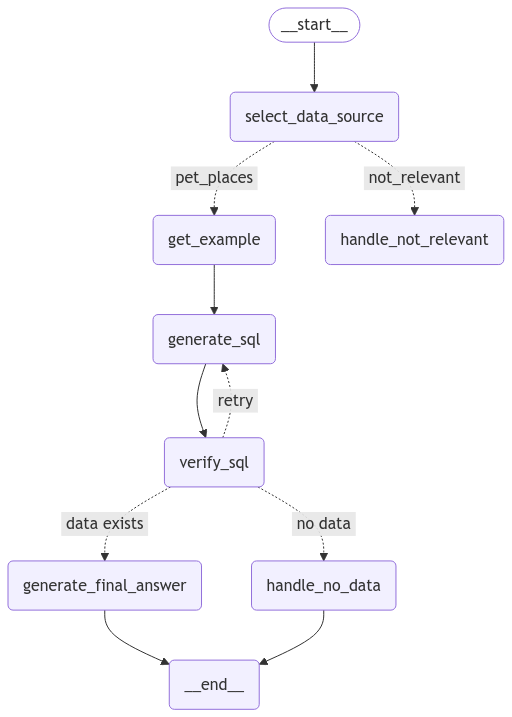

In [18]:
from IPython.display import Image, display

display(
    Image(app.get_graph(xray=True).draw_mermaid_png())
)  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다.

In [44]:
initial_state = GraphState(
    question="명절에도 영업하는 미술관 알려줘",
)

try:
    result = app.invoke(initial_state, {"recursion_limit": 7})
    print("\n", result["answer"])
except GraphRecursionError:
    print("에러가 발생했습니다. 다시 시도해주세요.")

children_places
<QUESTION> 서울 강동구에서 수유실이 있는 미술관을 추천해주세요. </QUESTION>
<SQL> SELECT * FROM children_places WHERE CTPRVN_NM = '서울특별시' AND SIGNGU_NM = '강동구' AND CTGRY_THREE_NM LIKE '%미술관%' AND NRSGRM_AT = 'Y' </SQL>

<QUESTION> 경기도에서 휴일에 운영하는 키즈존이 있는 시설을 알려주세요. </QUESTION>
<SQL> SELECT * FROM children_places WHERE CTPRVN_NM = '경기도' AND RSTDE_GUID_CN = '연중무휴' AND KIDS_ZONE_AT = 'Y' </SQL>

<QUESTION> 서울시 종로구에 있는 키즈존이 있는 시설을 알려주세요. </QUESTION>
<SQL> SELECT * FROM children_places WHERE CTPRVN_NM = '서울특별시' AND SIGNGU_NM = '종로구' AND KIDS_ZONE_AT = 'Y' </SQL>

 <SQL> SELECT * FROM children_places WHERE RSTDE_GUID_CN = '연중무휴' AND CTGRY_THREE_NM LIKE '%미술관%' </SQL>
Data Length:  60

 다음은 명절에도 영업하는 미술관 몇 곳입니다:

1. 63빌딩63스카이아트미술관: 서울특별시 영등포구 여의도동에 위치하며, 영업시간은 10:00~20:00입니다. 연중무휴로 운영되며, 입장료가 있습니다. 자세한 정보는 [홈페이지](https://www.63art.co.kr/home/63ART/main.do)에서 확인하실 수 있습니다.

2. 갤러리담: 서울특별시 종로구 안국동에 위치하며, 월-토 12:00~18:00, 일 12:00~17:00에 운영됩니다. 연중무휴로 운영되며, 입장료가 있습니다. 자세한 정보는 [홈페이지](http://www.gallerydam.c